In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from packages.DataProcessing import split_dataset
from packages.DataProcessing import tfrecords

plt.style.use('_mpl-gallery')

In [2]:
config = json.load(open("./conf/config.json"))

In [3]:
N_SPLITS = config["DataProcess"]["N_SPLITS"]
IMG_HEIGHT = config["DataProcess"]["IMG_HEIGHT"]
IMG_WIDTH = config["DataProcess"]["IMG_WIDTH"]
BATCH_SIZE = config["TrainCycle"]["BATCH_SIZE"]
PATIENCE = config["TrainCycle"]["PATIENCE"]
EPOCHS = config["TrainCycle"]["EPOCHS"]
INIT_LR = config["TrainCycle"]["INIT_LR"]
MAX_LR = config["TrainCycle"]["MAX_LR"]

In [4]:
# Data

df = pd.read_csv('./input/train_cultivar_mapping.csv')
df.dropna(inplace=True)

In [5]:
images = df['image'].to_numpy()
images = np.array(['./input/train_images/'+i for i in images])
images

array(['./input/train_images/2017-06-16__12-24-20-930.png',
       './input/train_images/2017-06-02__16-48-57-866.png',
       './input/train_images/2017-06-12__13-18-07-707.png', ...,
       './input/train_images/2017-06-28__10-20-32-417.png',
       './input/train_images/2017-06-28__12-47-02-714.png',
       './input/train_images/2017-06-04__13-12-56-053.png'], dtype='<U49')

In [6]:
num_images = len(images)
num_images

22193

In [7]:
cultivars = df['cultivar'].to_numpy()

In [8]:
class_names, counts = np.unique(cultivars, return_counts=True)
np.save("./output/class_names.npy", class_names)
num_classes = len(class_names)
num_classes

100

In [9]:
def get_onehot(label):
    one_hot = label == class_names
    return np.argmax(one_hot)

cultivars = np.array([get_onehot(cultivar) for cultivar in cultivars])
cultivars

array([73, 29, 99, ..., 18, 73, 58], dtype=int64)

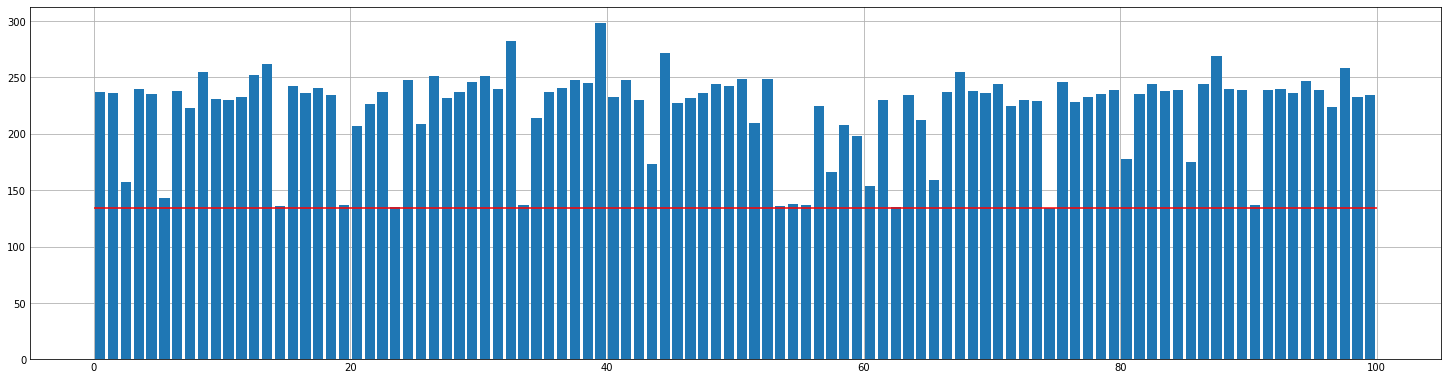

In [10]:
# EDA

plt.subplots(figsize=(20, 5))
plt.bar(np.arange(num_classes)+0.5, counts)
plt.hlines(counts.min(), 0, num_classes, colors='r')
plt.show()

In [11]:
# StratifiedKFold
ds_splits = split_dataset(images, cultivars, N_SPLITS=N_SPLITS)

train size: 16645
valid size: 5548


In [12]:
train_target = ds_splits['train'][1]
valid_target = ds_splits['valid'][1]
np.save("./output/train_target.npy", train_target)
np.save("./output/valid_target.npy", valid_target)

In [14]:
# Writing TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)

records.WriteTFRecords(ds_splits,
                       path='./output/tfrecords')

100%|██████████| 5548/5548 [10:56<00:00,  8.45it/s]
